In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install koreanize_matplotlib
!fc-list | grep NanumGothic
!apt-get install fonts-nanum*dd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 18.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package fonts-nanum*dd
E: Couldn't find any package by glob 'fonts-nanum*dd'
E: Couldn't find any package by regex 'fonts-nanum*dd'


In [ ]:
import koreanize_matplotlib
import warnings
warnings.simplefilter(action='ignore', category=Warning)

**제안된 얼굴 감지 계획 수립 : 퍼스널 컬러 논문에 따라 계획 수립**
- 논문 (Correlation between the Factors of Personal Color Diagnosis Guide and Brain Wave Analysis) : https://e-ajbc.org/journal/view.php?doi=10.20402/ajbc.2016.0071
- 퍼스널 컬러 팔레트와 피부색, 두피색, 눈동자색, 머리카락 색 간의 상관관계   (피어슨 상관계수(pearsonʼs correlation coefficient: r)) : 각 요인들 중 두피색이 가장 상관관계가 높았으며, 피부색>머리카락색>눈동자색 순


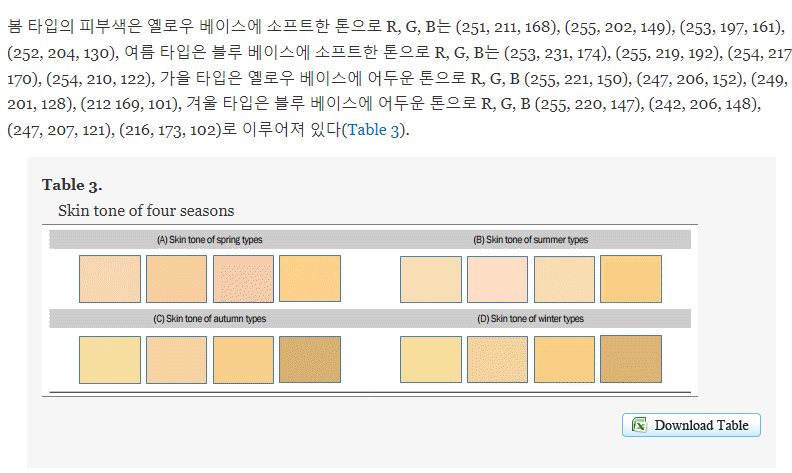

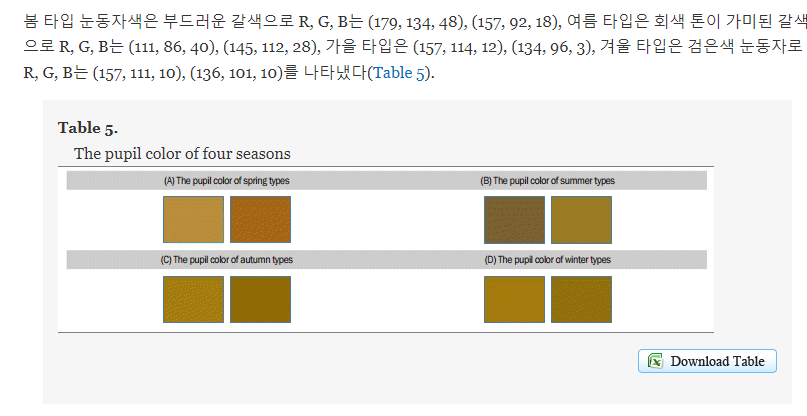

1.   이미지에서 얼굴을 감지
2.   얼굴 영역에서 눈, 눈썹, 입을 제외한 부분의 평균 피부색을 추출 (논문의 RGB값 사용)
3.   눈동자 색상을 추출 (논문의 RGB값 사용)
4.   추출된 피부색과 눈동자색을 바탕으로 가장 적합한 퍼스널 컬러 시즌을 결정 (피부색>눈동자색 순으로 가중치 부여)
5.   결과를 시각화
*   원본 이미지
* 얼굴 감지 결과
* 피부색 추출에 사용된 마스크
* 추출된 피부색
* 추출된 눈동자색
* 결정된 시즌의 색상 팔레트







## 1. 얼굴 감지 및 랜드마크 추출 함수

In [ ]:
import cv2
import dlib
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

# dlib의 얼굴 감지기와 랜드마크 예측기 로드
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor("/content/drive/MyDrive/Colab Notebooks/Project(Personal-Color-Analysis)/models/shape_predictor_68_face_landmarks.dat")

def detect_face_and_landmarks(image_path):
    # 이미지 로드
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 얼굴 감지
    faces = face_detector(image)
    if len(faces) == 0:
        raise ValueError("얼굴을 감지할 수 없습니다.")

    face = faces[0]
    landmarks = landmark_predictor(image, face)

    return image, face, landmarks

## 2. 피부색 및 눈동자색 추출 함수

In [ ]:
def extract_skin_and_eye_colors(image, landmarks):
    # 전체 얼굴 영역에서 피부색 추출
    face_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    points = []
    for i in range(17):  # 얼굴 윤곽선
        points.append((landmarks.part(i).x, landmarks.part(i).y))
    for i in range(26, 16, -1):  # 얼굴 윤곽선 (반대 방향)
        points.append((landmarks.part(i).x, landmarks.part(i).y))

    points = np.array(points, dtype=np.int32)
    cv2.fillPoly(face_mask, [points], 255)

    # 눈, 눈썹, 입 영역 제외
    eyes_mouth_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for i in range(36, 48):  # 눈
        cv2.circle(eyes_mouth_mask, (landmarks.part(i).x, landmarks.part(i).y), 5, 255, -1)
    for i in range(48, 68):  # 입
        cv2.circle(eyes_mouth_mask, (landmarks.part(i).x, landmarks.part(i).y), 5, 255, -1)
    for i in range(17, 27):  # 눈썹
        cv2.circle(eyes_mouth_mask, (landmarks.part(i).x, landmarks.part(i).y), 5, 255, -1)

    face_mask = cv2.subtract(face_mask, eyes_mouth_mask)

    skin_color = cv2.mean(image, mask=face_mask)[:3]

    # 눈동자색 추출
    left_eye = np.mean(image[landmarks.part(37).y:landmarks.part(41).y,
                             landmarks.part(36).x:landmarks.part(39).x], axis=(0, 1))
    right_eye = np.mean(image[landmarks.part(43).y:landmarks.part(47).y,
                              landmarks.part(42).x:landmarks.part(45).x], axis=(0, 1))
    eye_color = np.mean([left_eye, right_eye], axis=0)

    return skin_color, eye_color, face_mask

## 3.퍼스널 컬러 시즌 계산 함수

In [ ]:
def calculate_season(skin_color, eye_color):
    seasons = {
        "Spring": {
            "skin": [(251, 211, 168), (255, 202, 149), (253, 197, 161), (252, 204, 130)],
            "eye": [(179, 134, 48), (157, 92, 18)]
        },
        "Summer": {
            "skin": [(253, 231, 174), (255, 219, 192), (254, 217, 170), (254, 210, 122)],
            "eye": [(111, 86, 40), (145, 112, 28)]
        },
        "Autumn": {
            "skin": [(255, 221, 150), (247, 206, 152), (249, 201, 128), (212, 169, 101)],
            "eye": [(157, 114, 12), (134, 96, 3)]
        },
        "Winter": {
            "skin": [(255, 220, 147), (242, 206, 148), (247, 207, 121), (216, 173, 102)],
            "eye": [(157, 111, 10), (136, 101, 10)]
        }
    }

    skin_weight, eye_weight = 0.7, 0.3
    distances = {}
    for season, colors in seasons.items():
        skin_distances = [euclidean_distances([skin_color], [s])[0][0] for s in colors["skin"]]
        eye_distances = [euclidean_distances([eye_color], [e])[0][0] for e in colors["eye"]]
        distances[season] = skin_weight * min(skin_distances) + eye_weight * min(eye_distances)

    return min(distances, key=distances.get)

## 4. 퍼스널 컬러 시즌 확률 계산 함수

In [ ]:
def calculate_season_probabilities(skin_color, eye_color):
    seasons = {
        "Spring": {
            "skin": [(251, 211, 168), (255, 202, 149), (253, 197, 161), (252, 204, 130)],
            "eye": [(179, 134, 48), (157, 92, 18)]
        },
        "Summer": {
            "skin": [(253, 231, 174), (255, 219, 192), (254, 217, 170), (254, 210, 122)],
            "eye": [(111, 86, 40), (145, 112, 28)]
        },
        "Autumn": {
            "skin": [(255, 221, 150), (247, 206, 152), (249, 201, 128), (212, 169, 101)],
            "eye": [(157, 114, 12), (134, 96, 3)]
        },
        "Winter": {
            "skin": [(255, 220, 147), (242, 206, 148), (247, 207, 121), (216, 173, 102)],
            "eye": [(157, 111, 10), (136, 101, 10)]
        }
    }

    skin_weight, eye_weight = 0.7, 0.3
    distances = {}
    for season, colors in seasons.items():
        skin_distances = [euclidean_distances([skin_color], [s])[0][0] for s in colors["skin"]]
        eye_distances = [euclidean_distances([eye_color], [e])[0][0] for e in colors["eye"]]
        distances[season] = skin_weight * min(skin_distances) + eye_weight * min(eye_distances)

    # 거리의 역수를 사용하여 확률 계산
    total = sum(1/d for d in distances.values())
    probabilities = {season: (1/d)/total * 100 for season, d in distances.items()}

    return probabilities

## 5. 결과 시각화 함수

In [ ]:
def visualize_results(image, face, skin_color, eye_color, season, face_mask):
    fig, axs = plt.subplots(1, 6, figsize=(30, 5))
    fig.suptitle(f'Personal Color Analysis: {season}', fontsize=16)

    # 원본 이미지
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # 얼굴 감지 이미지
    face_image = image.copy()
    cv2.rectangle(face_image, (face.left(), face.top()), (face.right(), face.bottom()), (0, 255, 0), 2)
    axs[1].imshow(face_image)
    axs[1].set_title('Detected Face')
    axs[1].axis('off')

    # 피부색 추출 마스크
    axs[2].imshow(face_mask, cmap='gray')
    axs[2].set_title('Skin Color Extraction Mask')
    axs[2].axis('off')

    # 추출된 피부색
    skin_patch = np.full((100, 100, 3), skin_color, dtype=np.uint8)
    axs[3].imshow(skin_patch)
    axs[3].set_title(f'Skin Color: RGB{tuple(np.round(skin_color).astype(int))}')
    axs[3].axis('off')

    # 추출된 눈동자색
    eye_patch = np.full((100, 100, 3), eye_color, dtype=np.uint8)
    axs[4].imshow(eye_patch)
    axs[4].set_title(f'Eye Color: RGB{tuple(eye_color.astype(int))}')
    axs[4].axis('off')

    # 시즌 팔레트
    seasons = {
        "Spring": {
            "skin": [(251, 211, 168), (255, 202, 149), (253, 197, 161), (252, 204, 130)],
            "eye": [(179, 134, 48), (157, 92, 18)]
        },
        "Summer": {
            "skin": [(253, 231, 174), (255, 219, 192), (254, 217, 170), (254, 210, 122)],
            "eye": [(111, 86, 40), (145, 112, 28)]
        },
        "Autumn": {
            "skin": [(255, 221, 150), (247, 206, 152), (249, 201, 128), (212, 169, 101)],
            "eye": [(157, 114, 12), (134, 96, 3)]
        },
        "Winter": {
            "skin": [(255, 220, 147), (242, 206, 148), (247, 207, 121), (216, 173, 102)],
            "eye": [(157, 111, 10), (136, 101, 10)]
        }
    }

    palette = seasons[season]["skin"] + seasons[season]["eye"]
    palette_image = np.array(palette).reshape(1, -1, 3)
    axs[5].imshow(palette_image)
    axs[5].set_title(f'{season} Color Palette')
    axs[5].axis('off')

    plt.tight_layout()
    plt.show()

## 6. 확률 시각화 함수

In [ ]:
def visualize_probabilities(probabilities):
    seasons = list(probabilities.keys())
    probs = list(probabilities.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(seasons, probs)
    plt.title('Personal Color Season Probabilities')
    plt.xlabel('Seasons')
    plt.ylabel('Probability (%)')
    plt.ylim(0, 100)

    # 바 위에 확률 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%',
                 ha='center', va='bottom')

    plt.show()

## 7. 메인 실행 코드

In [ ]:
def main(image_path):
    try:
        # 얼굴 감지 및 랜드마크 추출
        image, face, landmarks = detect_face_and_landmarks(image_path)

        # 피부색 및 눈동자색 추출
        skin_color, eye_color, face_mask = extract_skin_and_eye_colors(image, landmarks)

        # 퍼스널 컬러 시즌 계산
        result = calculate_season(skin_color, eye_color)

        print(f"당신의 퍼스널 컬러 시즌은 {result}입니다.")
        print(f"추출된 피부색: RGB{tuple(np.round(skin_color).astype(int))}")
        print(f"추출된 눈동자색: RGB{tuple(eye_color.astype(int))}")

        # 결과 시각화
        visualize_results(image, face, skin_color, eye_color, result, face_mask)

        # 시즌별 확률 계산 및 시각화
        probabilities = calculate_season_probabilities(skin_color, eye_color)
        visualize_probabilities(probabilities)

        # 시즌별 확률 출력
        print("\n시즌별 확률:")
        for season, prob in probabilities.items():
            print(f"{season}: {prob:.1f}%")
    except Exception as e:
        print(f"오류 발생: {e}")

당신의 퍼스널 컬러 시즌은 Spring입니다.
추출된 피부색: RGB(206, 176, 163)
추출된 눈동자색: RGB(135, 117, 115)


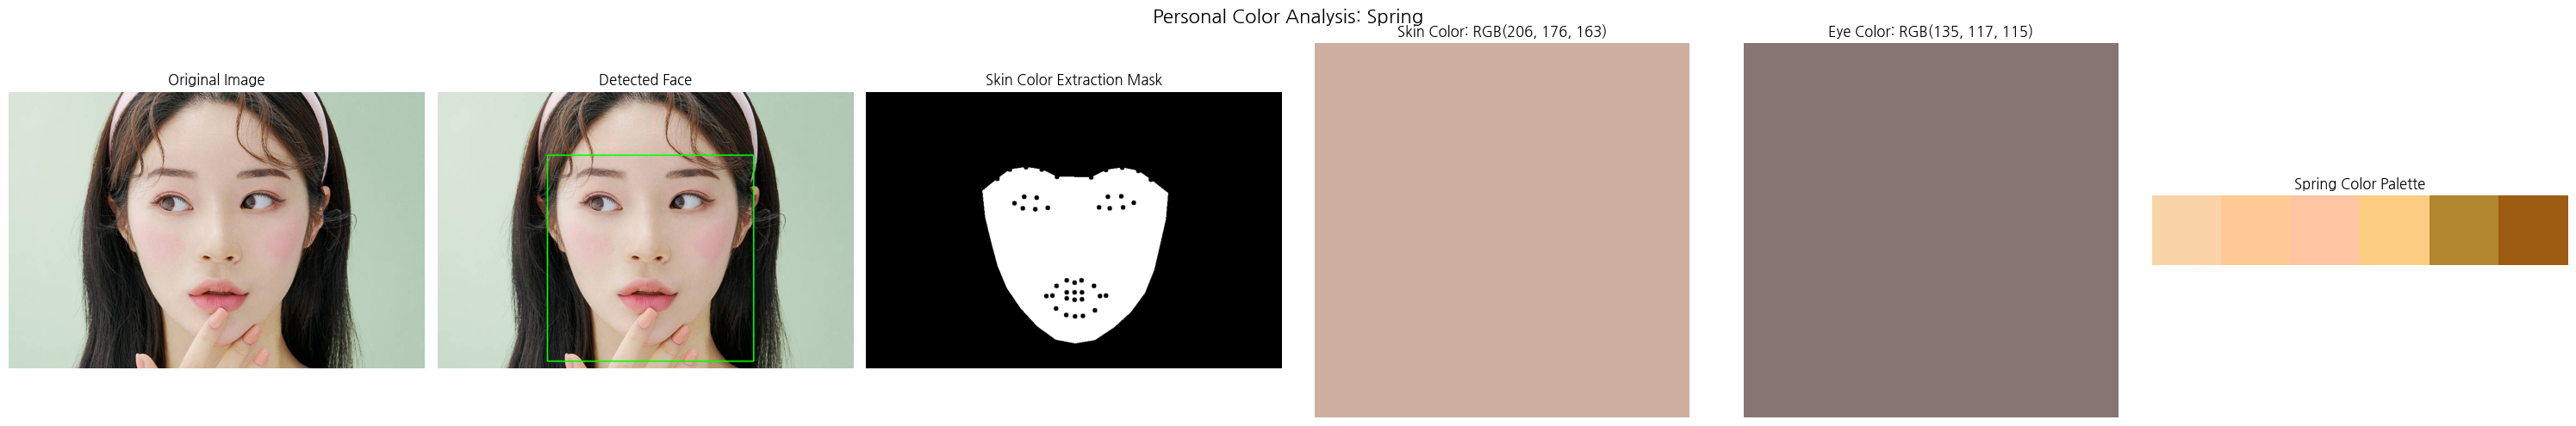

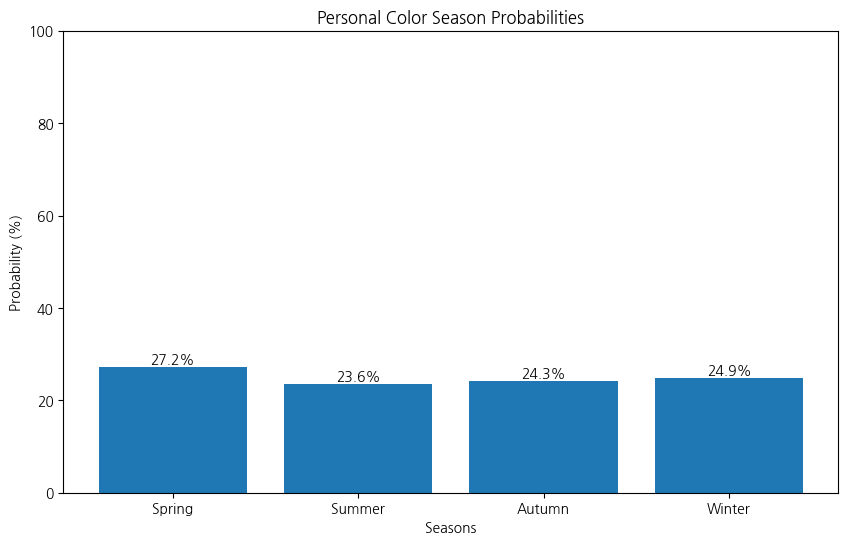


시즌별 확률:
Spring: 27.2%
Summer: 23.6%
Autumn: 24.3%
Winter: 24.9%


In [ ]:
# 메인 코드 실행1(Spring)
image_path = '/content/drive/MyDrive/Colab Notebooks/Project(Personal-Color-Analysis)/testimg1.jpg'
main(image_path)

당신의 퍼스널 컬러 시즌은 Summer입니다.
추출된 피부색: RGB(223, 196, 189)
추출된 눈동자색: RGB(115, 100, 110)


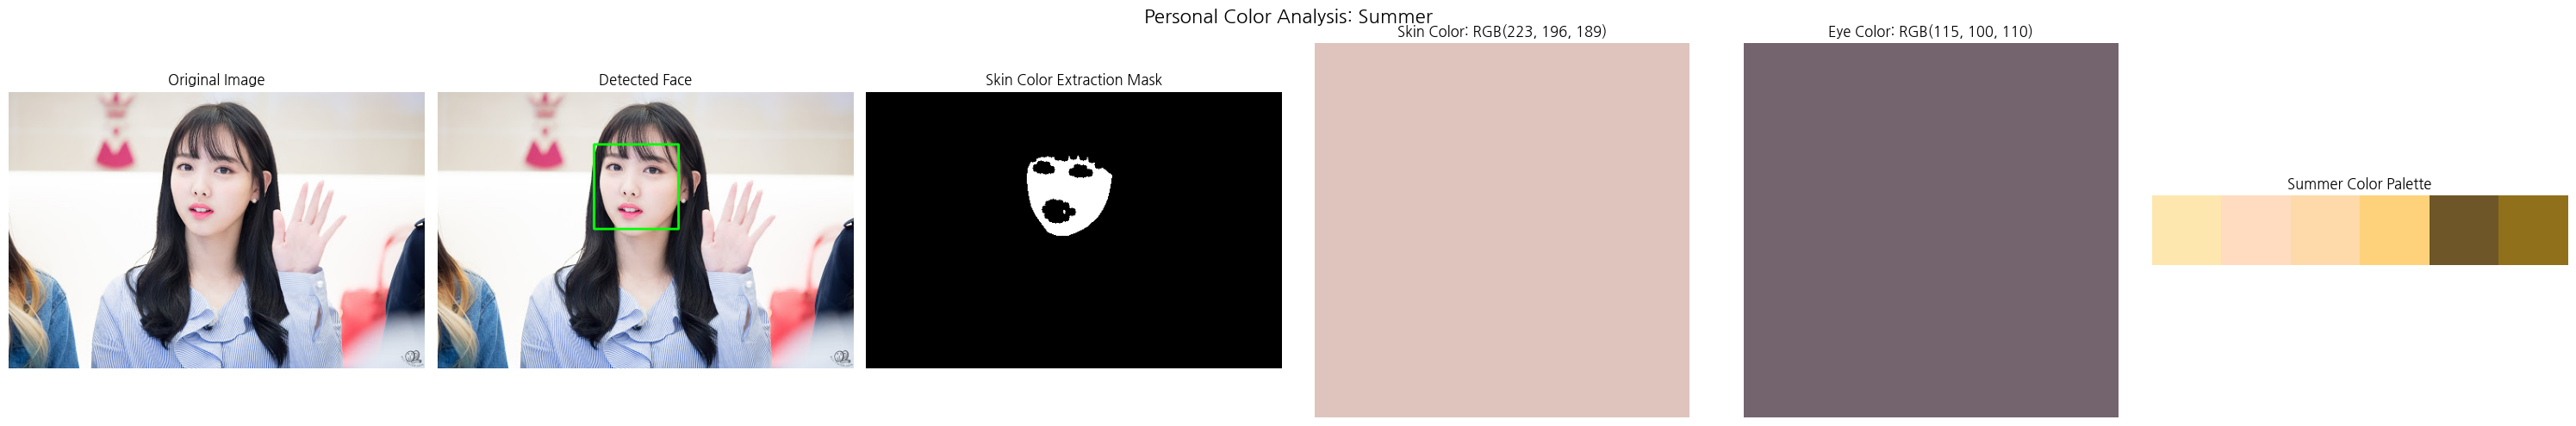

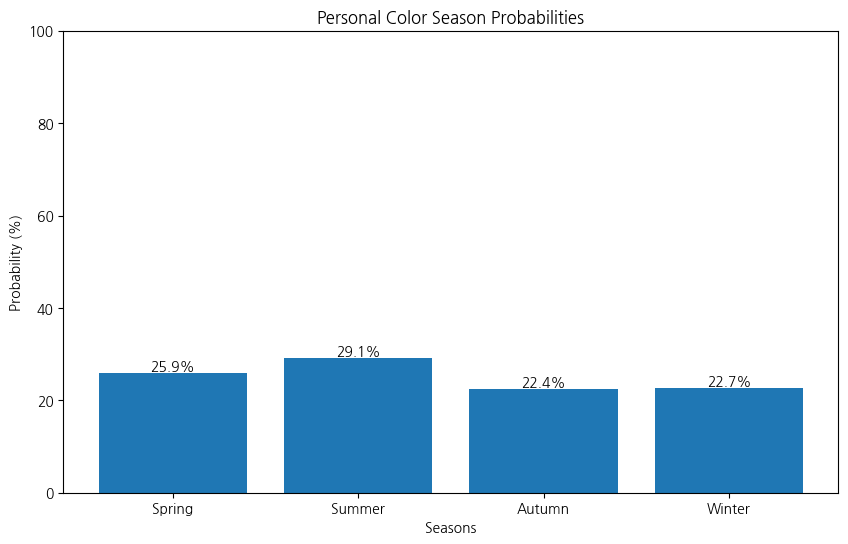


시즌별 확률:
Spring: 25.9%
Summer: 29.1%
Autumn: 22.4%
Winter: 22.7%


In [ ]:
# 메인 코드 실행2(Summer)
image_path = '/content/drive/MyDrive/Colab Notebooks/Project(Personal-Color-Analysis)/testimg2.jpg'
main(image_path)

당신의 퍼스널 컬러 시즌은 Autumn입니다.
추출된 피부색: RGB(173, 135, 128)
추출된 눈동자색: RGB(97, 79, 83)


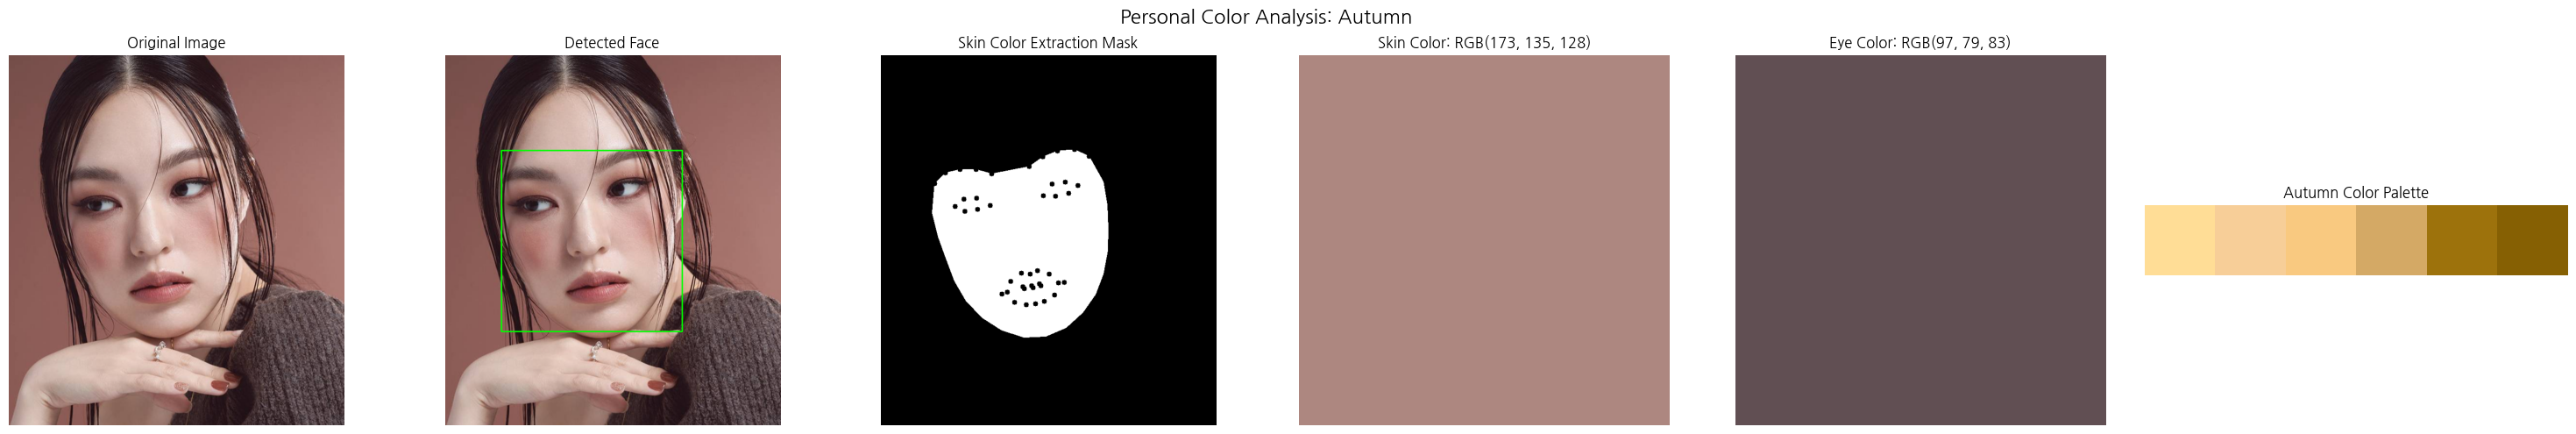

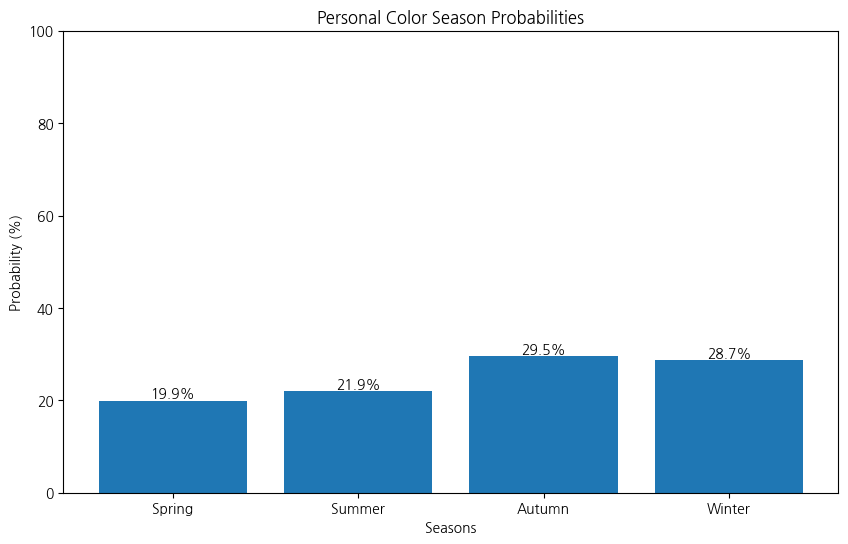


시즌별 확률:
Spring: 19.9%
Summer: 21.9%
Autumn: 29.5%
Winter: 28.7%


In [ ]:
# 메인 코드 실행3(Autumn)
image_path = '/content/drive/MyDrive/Colab Notebooks/Project(Personal-Color-Analysis)/testimg3.PNG'
main(image_path)

당신의 퍼스널 컬러 시즌은 Winter입니다.
추출된 피부색: RGB(201, 155, 146)
추출된 눈동자색: RGB(118, 102, 106)


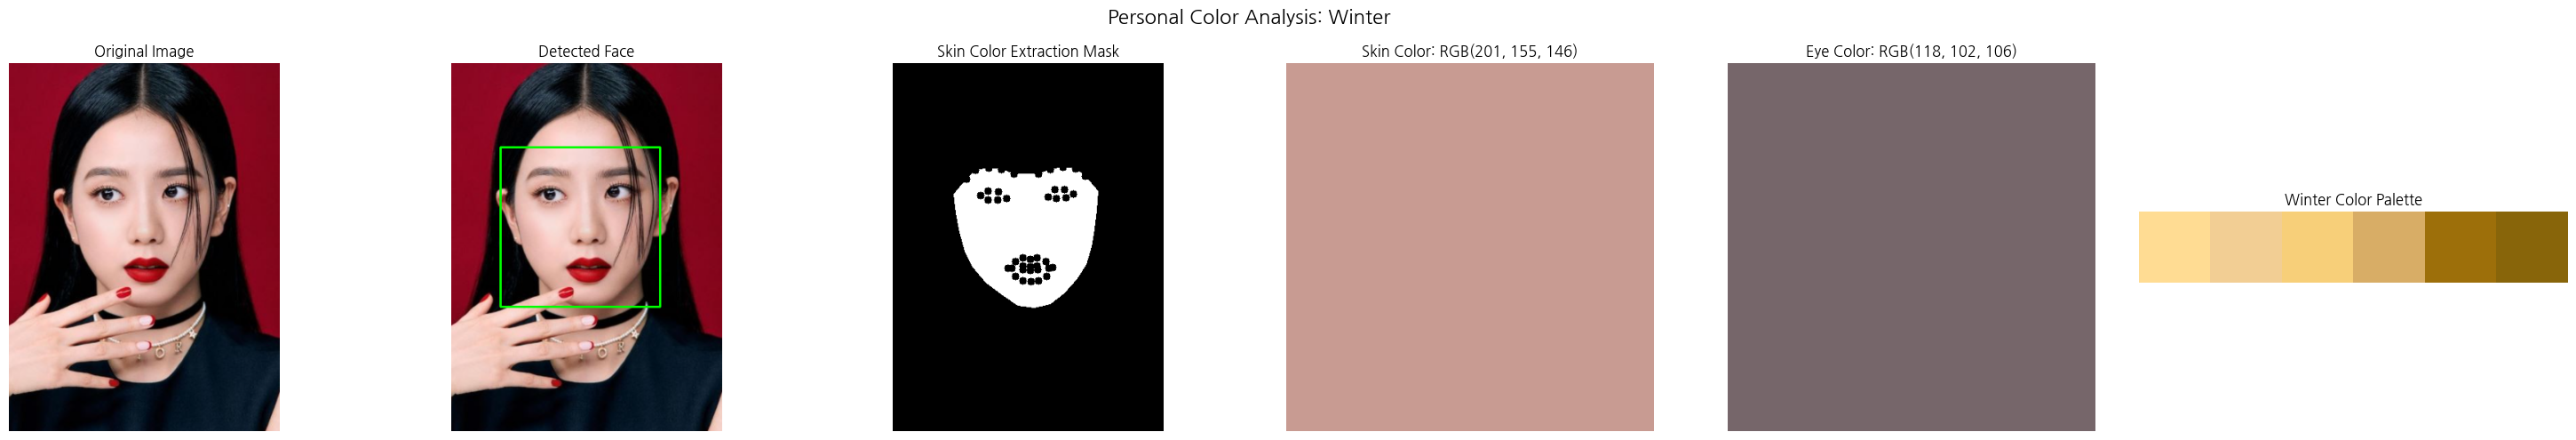

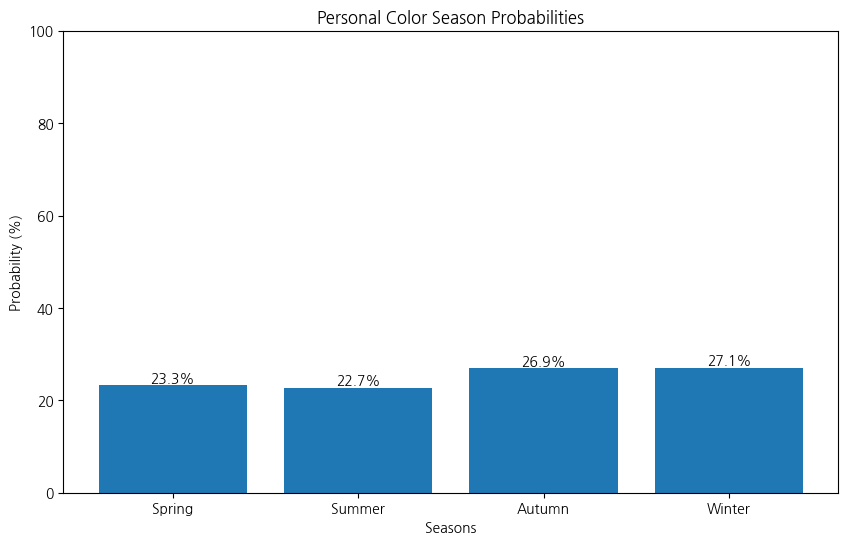


시즌별 확률:
Spring: 23.3%
Summer: 22.7%
Autumn: 26.9%
Winter: 27.1%


In [ ]:
# 메인 코드 실행4(Winter)
image_path = '/content/drive/MyDrive/Colab Notebooks/Project(Personal-Color-Analysis)/testimg4.PNG'
main(image_path)

## ** 모델 만들기**

##  1. 필요한 라이브러리 및 클래스 정의

In [ ]:
import cv2
import dlib
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import pickle

class PersonalColorAnalyzer:
    def __init__(self, face_detector, landmark_predictor):
        self.face_detector = face_detector
        self.landmark_predictor = landmark_predictor
        self.seasons = {
            "Spring": {
                "skin": [(251, 211, 168), (255, 202, 149), (253, 197, 161), (252, 204, 130)],
                "eye": [(179, 134, 48), (157, 92, 18)]
            },
            "Summer": {
                "skin": [(253, 231, 174), (255, 219, 192), (254, 217, 170), (254, 210, 122)],
                "eye": [(111, 86, 40), (145, 112, 28)]
            },
            "Autumn": {
                "skin": [(255, 221, 150), (247, 206, 152), (249, 201, 128), (212, 169, 101)],
                "eye": [(157, 114, 12), (134, 96, 3)]
            },
            "Winter": {
                "skin": [(255, 220, 147), (242, 206, 148), (247, 207, 121), (216, 173, 102)],
                "eye": [(157, 111, 10), (136, 101, 10)]
            }
        }
        self.skin_weight = 0.7
        self.eye_weight = 0.3

    def extract_colors(self, image_path):
        # 이미지 로드
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 얼굴 감지
        faces = self.face_detector(image)
        if len(faces) == 0:
            raise ValueError("얼굴을 감지할 수 없습니다.")

        face = faces[0]
        landmarks = self.landmark_predictor(image, face)

        # 전체 얼굴 영역에서 피부색 추출
        face_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        points = []
        for i in range(17):  # 얼굴 윤곽선
            points.append((landmarks.part(i).x, landmarks.part(i).y))
        for i in range(26, 16, -1):  # 얼굴 윤곽선 (반대 방향)
            points.append((landmarks.part(i).x, landmarks.part(i).y))

        points = np.array(points, dtype=np.int32)
        cv2.fillPoly(face_mask, [points], 255)

        # 눈, 눈썹, 입 영역 제외
        eyes_mouth_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        for i in range(36, 48):  # 눈
            cv2.circle(eyes_mouth_mask, (landmarks.part(i).x, landmarks.part(i).y), 5, 255, -1)
        for i in range(48, 68):  # 입
            cv2.circle(eyes_mouth_mask, (landmarks.part(i).x, landmarks.part(i).y), 5, 255, -1)
        for i in range(17, 27):  # 눈썹
            cv2.circle(eyes_mouth_mask, (landmarks.part(i).x, landmarks.part(i).y), 5, 255, -1)

        face_mask = cv2.subtract(face_mask, eyes_mouth_mask)
        skin_color = cv2.mean(image, mask=face_mask)[:3]

        # 눈동자색 추출
        left_eye = np.mean(image[landmarks.part(37).y:landmarks.part(41).y,
                                 landmarks.part(36).x:landmarks.part(39).x], axis=(0, 1))
        right_eye = np.mean(image[landmarks.part(43).y:landmarks.part(47).y,
                                  landmarks.part(42).x:landmarks.part(45).x], axis=(0, 1))
        eye_color = np.mean([left_eye, right_eye], axis=0)

        return skin_color, eye_color, image, face, face_mask

    def calculate_season(self, skin_color, eye_color):
        distances = {}
        for season, colors in self.seasons.items():
            skin_distances = [euclidean_distances([skin_color], [s])[0][0] for s in colors["skin"]]
            eye_distances = [euclidean_distances([eye_color], [e])[0][0] for e in colors["eye"]]
            distances[season] = self.skin_weight * min(skin_distances) + self.eye_weight * min(eye_distances)
        return min(distances, key=distances.get)

    def calculate_season_probabilities(self, skin_color, eye_color):
        distances = {}
        for season, colors in self.seasons.items():
            skin_distances = [euclidean_distances([skin_color], [s])[0][0] for s in colors["skin"]]
            eye_distances = [euclidean_distances([eye_color], [e])[0][0] for e in colors["eye"]]
            distances[season] = self.skin_weight * min(skin_distances) + self.eye_weight * min(eye_distances)
        total = sum(1/d for d in distances.values())
        probabilities = {season: (1/d)/total * 100 for season, d in distances.items()}
        return probabilities

    def analyze(self, image_path):
        skin_color, eye_color, image, face, face_mask = self.extract_colors(image_path)
        season = self.calculate_season(skin_color, eye_color)
        probabilities = self.calculate_season_probabilities(skin_color, eye_color)
        return season, probabilities, skin_color, eye_color, image, face, face_mask

## 2. 모델 저장 및 로드

In [ ]:
# dlib의 얼굴 감지기와 랜드마크 예측기 로드
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor("/content/drive/MyDrive/Colab Notebooks/Project(Personal-Color-Analysis)/models/shape_predictor_68_face_landmarks.dat")

analyzer = PersonalColorAnalyzer(face_detector, landmark_predictor)

# 모델을 pkl 파일로 저장
with open('/content/drive/MyDrive/Colab Notebooks/Project(Personal-Color-Analysis)/models/personal_color_analyzer.pkl', 'wb') as file:
    pickle.dump(analyzer, file)
print("모델이 성공적으로 저장되었습니다.")

모델이 성공적으로 저장되었습니다.


## 3. 모델 로드 및 사용 (Django에서~)

계산된 시즌: Winter
시즌별 확률:
Spring: 23.3%
Summer: 22.7%
Autumn: 26.9%
Winter: 27.1%


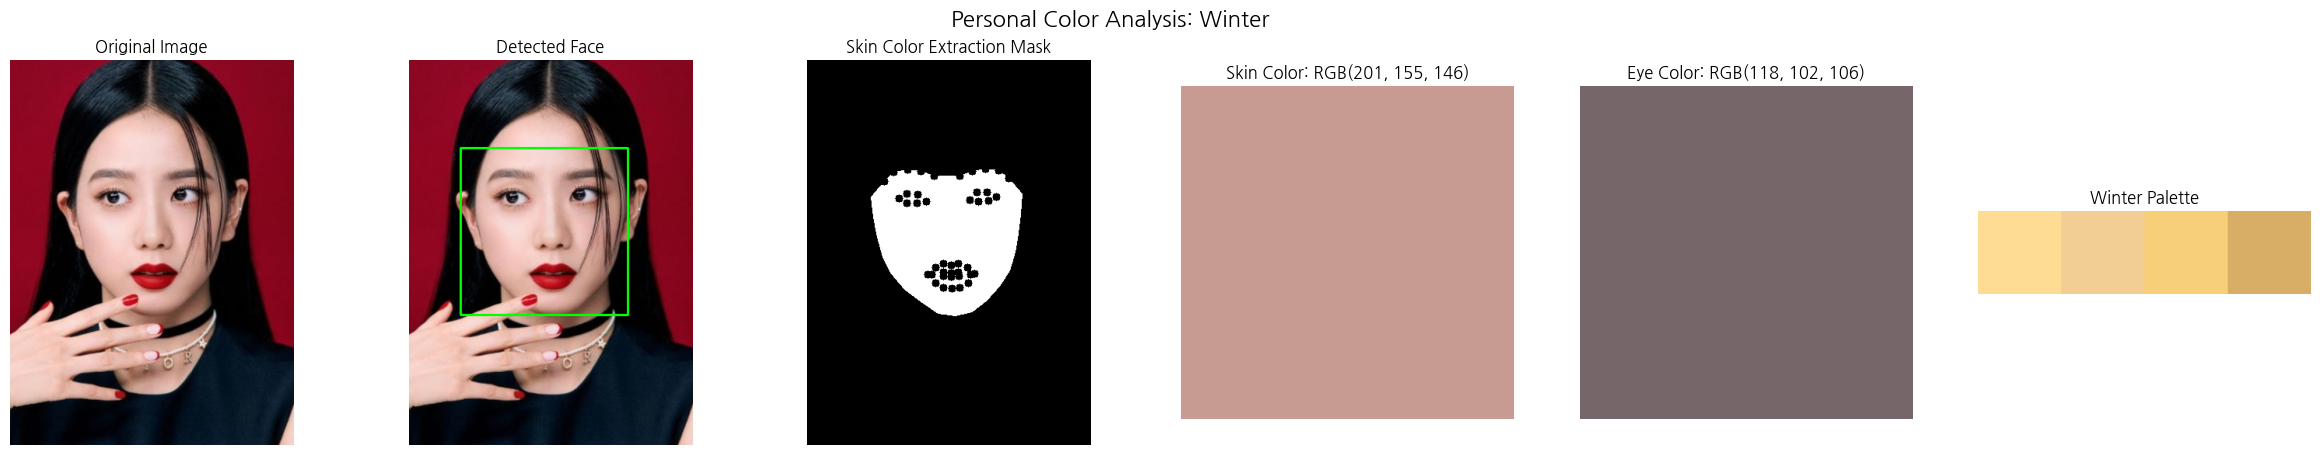

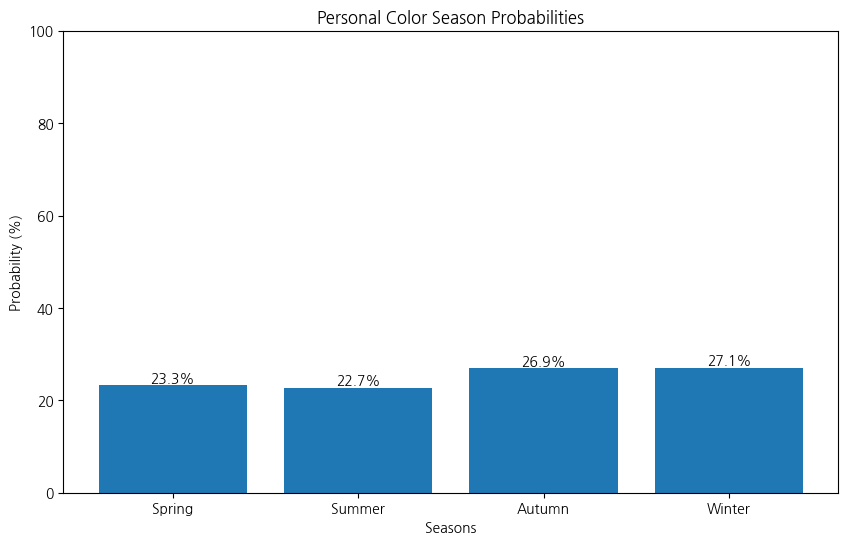

In [ ]:
# pkl 파일에서 퍼스널 컬러 분석기 로드
with open('/content/drive/MyDrive/Colab Notebooks/Project(Personal-Color-Analysis)/models/personal_color_analyzer.pkl', 'rb') as file:
    analyzer = pickle.load(file)

# 이미지 경로
image_path = '/content/drive/MyDrive/Colab Notebooks/Project(Personal-Color-Analysis)/testimg4.PNG'

# 퍼스널 컬러 분석
season, probabilities, skin_color, eye_color, image, face, face_mask = analyzer.analyze(image_path)

# 결과 출력
print(f"계산된 시즌: {season}")
print("시즌별 확률:")
for season, prob in probabilities.items():
    print(f"{season}: {prob:.1f}%")

# 결과 시각화 함수
def visualize_results(image, face, skin_color, eye_color, season, face_mask):
    fig, axs = plt.subplots(1, 6, figsize=(30, 5))
    fig.suptitle(f'Personal Color Analysis: {season}', fontsize=16)

    # 원본 이미지
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # 얼굴 감지 이미지
    face_image = image.copy()
    cv2.rectangle(face_image, (face.left(), face.top()), (face.right(), face.bottom()), (0, 255, 0), 2)
    axs[1].imshow(face_image)
    axs[1].set_title('Detected Face')
    axs[1].axis('off')

    # 피부색 추출 마스크
    axs[2].imshow(face_mask, cmap='gray')
    axs[2].set_title('Skin Color Extraction Mask')
    axs[2].axis('off')

    # 추출된 피부색
    skin_patch = np.full((100, 100, 3), skin_color, dtype=np.uint8)
    axs[3].imshow(skin_patch)
    axs[3].set_title(f'Skin Color: RGB{tuple(np.round(skin_color).astype(int))}')
    axs[3].axis('off')

    # 추출된 눈동자색
    eye_patch = np.full((100, 100, 3), eye_color, dtype=np.uint8)
    axs[4].imshow(eye_patch)
    axs[4].set_title(f'Eye Color: RGB{tuple(eye_color.astype(int))}')
    axs[4].axis('off')

    # 시즌 팔레트
    seasons = analyzer.seasons
    palette = np.zeros((100, 100 * len(seasons[season]["skin"]), 3), dtype=np.uint8)
    for i, color in enumerate(seasons[season]["skin"]):
        palette[:, i*100:(i+1)*100] = color
    axs[5].imshow(palette)
    axs[5].set_title(f'{season} Palette')
    axs[5].axis('off')

    plt.show()

# 결과 시각화
visualize_results(image, face, skin_color, eye_color, season, face_mask)

# 시즌별 확률 시각화 함수
def visualize_probabilities(probabilities):
    seasons = list(probabilities.keys())
    probs = list(probabilities.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(seasons, probs)
    plt.title('Personal Color Season Probabilities')
    plt.xlabel('Seasons')
    plt.ylabel('Probability (%)')
    plt.ylim(0, 100)

    # 바 위에 확률 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%',
                 ha='center', va='bottom')

    plt.show()

# 시즌별 확률 시각화
visualize_probabilities(probabilities)

## Vue에서~



```
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>퍼스널컬러 진단 결과</title>
    <!-- Include Highcharts library -->
    <script src="https://code.highcharts.com/highcharts.js"></script>
    <script src="https://code.highcharts.com/highcharts-3d.js"></script>
</head>
<body>

<!-- Container for the chart -->
<div id="container" style="width: 600px; height: 400px; margin: 0 auto"></div>

<!-- Script to generate the chart -->
<script>
    // Highcharts chart configuration
    Highcharts.chart('container', {
        chart: {
            type: 'pie',
            options3d: {
                enabled: true,
                alpha: 45
            }
        },
        title: {
            text: '퍼스널컬러 진단 결과',
            align: 'left'
        },
        subtitle: {
            text: '이미지 분석 결과',
            align: 'left'
        },
        tooltip: {
            pointFormat: '{series.name}: <b>{point.percentage:.2f}%</b>'
        },
        plotOptions: {
            pie: {
                allowPointSelect: true,
                cursor: 'pointer',
                depth: 35,
                innerSize: 100,
                dataLabels: {
                    enabled: true,
                    format: '<b>{point.name}</b>: {point.percentage:.2f} %'
                },
                showInLegend: true
            }
        },
        series: [{
            name: 'Seasons',
            colorByPoint: true,
            data: [
                { name: 'Spring', y: 23.3, color: '#FF6F61' },
                { name: 'Summer', y: 22.7, color: '#98FF98' },
                { name: 'Autumn', y: 26.9, color: '#D2B48C' },
                { name: 'Winter', y: 27.1, color: '#000080' }
            ]
        }]
    });
</script>

</body>
</html>

```



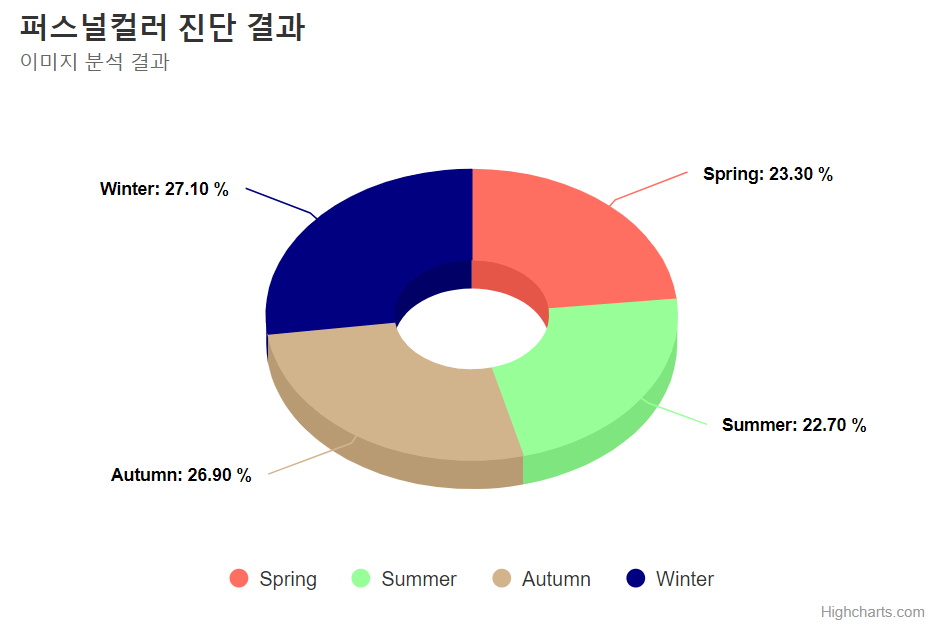



```
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Highcharts Variable Pie Chart</title>
    <!-- Highcharts JavaScript -->
    <script src="https://code.highcharts.com/highcharts.js"></script>
    <script src="https://code.highcharts.com/modules/variable-pie.js"></script>
    <style>
        #container {
            height: 500px; /* Adjust the height as needed */
            width: 100%; /* Adjust the width as needed */
            margin: 0 auto; /* Center the chart */
        }
    </style>
</head>
<body>
    <div id="container"></div>

    <script>
        Highcharts.chart('container', {
            chart: {
                type: 'variablepie'
            },
            title: {
                text: '퍼스널 컬러 진단 결과'
            },
            tooltip: {
                headerFormat: '',
                pointFormat: '<span style="color:{point.color}">\u25CF</span> <b>{point.name}</b><br/>' +
                    'Percentage: <b>{point.y:.1f}%</b><br/>' +
                    'Size (simulated): <b>{point.z:.1f}</b><br/>'
            },
            plotOptions: {
                variablepie: {
                    dataLabels: {
                        enabled: true,
                        format: '{point.name}: {point.y:.1f}%',
                        style: {
                            fontSize: '12px',
                            textOutline: 'none'
                        },
                        filter: {
                            operator: '>',
                            property: 'percentage',
                            value: 10
                        }
                    }
                }
            },
            series: [{
                minPointSize: 10,
                innerSize: '20%',
                zMin: 0,
                name: 'Seasons',
                borderRadius: 5,
                data: [{
                    name: 'Spring',
                    y: 23.3,  // Percentage
                    z: 23.3   // Simulated size
                }, {
                    name: 'Summer',
                    y: 22.7,
                    z: 22.7
                }, {
                    name: 'Autumn',
                    y: 26.9,
                    z: 26.9
                }, {
                    name: 'Winter',
                    y: 27.1,
                    z: 27.1
                }],
                colors: [
                    '#FF6F61', // Spring
                    '#98FF98', // Summer
                    '#D2B48C', // Autumn
                    '#000080'  // Winter
                ]
            }]
        });
    </script>
</body>
</html>

```



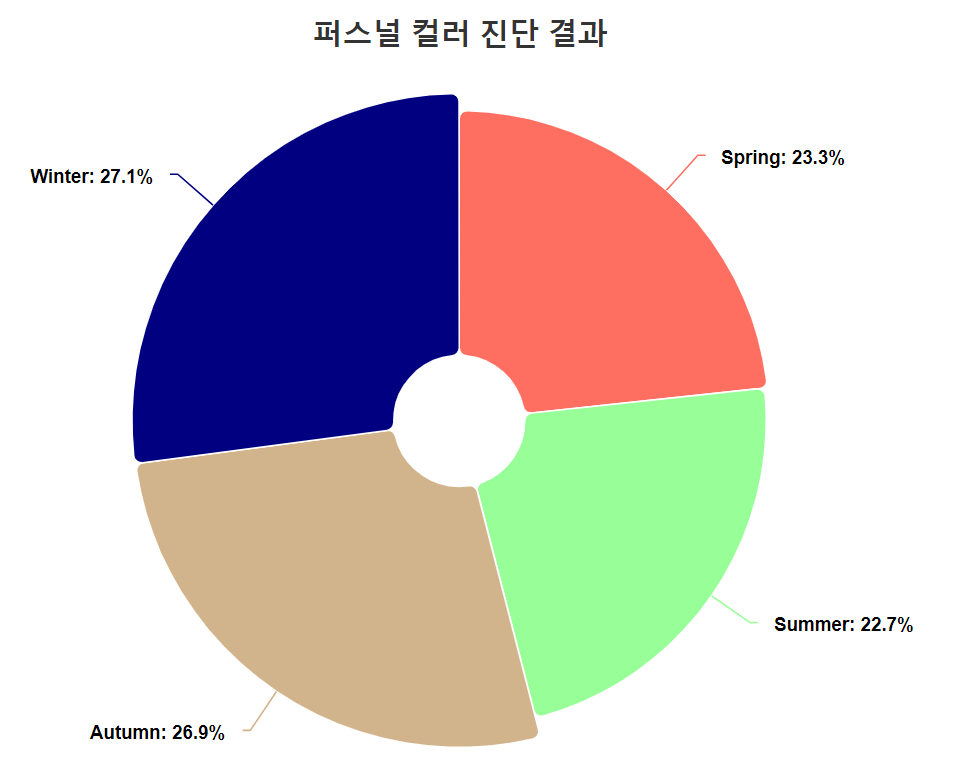